In [1]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(theta, m, x):
	return np.cos(m*theta - x*np.sin(theta))

In [3]:
def J(m, x):
	I, err = integrate.quad(f, 0, np.pi, args = (m, x))
	return I/np.pi

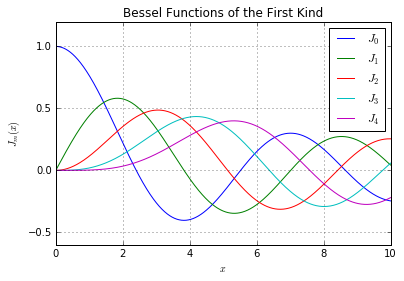

In [4]:
X = np.linspace(0,10,1000)
[plt.plot(X, np.array([J(m,x) for x in X]), label = '$J_'+str(m)+'$') for m in range(5)]
plt.legend()
plt.title('Bessel Functions of the First Kind')
plt.xlabel('$x$')
plt.ylabel('$J_m(x)$')
plt.grid()
plt.show()